# CQR on simulated data

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import lightgbm as lgb
import pickle
import warnings
from scipy.stats import randint, uniform
from mapie.regression import MapieQuantileRegressor

import sys
import os
from pathlib import Path
PROJ_ROOT = Path(os.getcwd()).parent # add project root file to the python paths
sys.path.append(str(PROJ_ROOT))

path_to_db = str(PROJ_ROOT) + "/data/db/option_prices_processed.db"

## Load training and calibration data

We will load data, and organize it into subsample of different sizes, as in the previous notebooks.

In [3]:
data = pd.read_csv('../data/simulated/simulation_1.csv')
data['S'] = data['S']/data['K']
data['C'] = data['C']/data['K']
data.drop('K', axis=1, inplace=True)

# Split into samples by sample_id
sample_ids = data['sample_id'].unique()
samples = [data.loc[data['sample_id']==id] for id in sample_ids]
sample_lens = [len(sample) for sample in samples]

data_sets = {}

for sample in samples:
    id = sample['sample_id'].iloc[0]
    size = len(sample)
    sample = sample.drop('sample_id', axis=1)

    train, validation = train_test_split(sample, test_size=0.2, random_state=42)
    proper_train, calibration = train_test_split(train, test_size=0.25, random_state=42) # 0.25 x 0.8 = 0.2

    data_sets[id] = [train, proper_train, calibration, validation]

## Fit CQR (MAPIE) models

In [4]:
refit_cqr = False
save_cp_models = False
load_cp_models = False

In [5]:
cp_models = {}

if refit_cqr:
    hyperparams_cp = {}
    
    for id in sample_ids:
        temp_res = pd.read_csv(f'../models/simulation_1/sample_{id}/results_proper_train.csv')

        # take the row of temp_res with the lowest mae, make a dict out of it, and delete the mae key
        hyperparams_cp[id] = temp_res.loc[temp_res.loc[:,'mae'].idxmin(),:].to_dict()
        del hyperparams_cp[id]['mae']

        # convert the string representation of the hyperparameters to integers
        for key in ['n_estimators', 'num_leaves', 'max_depth']:
            hyperparams_cp[id][key] = int(hyperparams_cp[id][key])
        
        hyperparams_cp[id]['learning_rate'] = float(hyperparams_cp[id]['learning_rate'])

        _ , proper_train, calibration, _ = data_sets[id]

        X_proper_train, y_proper_train = proper_train.drop('C', axis=1), proper_train['C']
        X_calib, y_calib = calibration.drop('C', axis=1), calibration['C']

        # make an estimator with the best hyperparameters, initialize alpha=0.5 but MAPIE will overwrite it
        # when calibrating the model
        estimator = lgb.LGBMRegressor(**hyperparams_cp[id], objective='quantile', alpha=0.5, random_state=123456)

        mapie = MapieQuantileRegressor(estimator,  alpha=0.1, method='quantile', cv='split')
        mapie.fit(
            X_proper_train,
            y_proper_train,
            X_calib=X_calib,
            y_calib=y_calib,
            random_state=123456,
        )
        cp_models[id] = mapie
    
# save confomalized models
if save_cp_models:
    for id in sample_ids:
        with open(f'../models/simulation_1/sample_{id}/cqr_model.pkl', 'wb') as f:
            pickle.dump(cp_models[id], f)
        
# load confomalized models
if load_cp_models:
    for id in sample_ids:
        with open(f'../models/simulation_1/sample_{id}/cqr_model.pkl', 'rb') as f:
            cp_models[id] = pickle.load(f)

## Fit non-conformal QR models

In [6]:
refit_qr = False
save_non_cp_models = False
load_non_cp_models = False

In [7]:
noncp_models = {}

if refit_qr:
    hyperparams_noncp = {}

    for id in sample_ids:
        temp_res = pd.read_csv(f'../models/simulation_1/sample_{id}/results_train.csv')
        hyperparams_noncp[id] = temp_res.loc[temp_res.loc[:,'mae'].idxmin(),:].to_dict()
        del hyperparams_noncp[id]['mae']

        # convert the string representation of the hyperparameters to integers
        for key in ['n_estimators', 'num_leaves', 'max_depth']:
            hyperparams_noncp[id][key] = int(hyperparams_noncp[id][key])
        
        hyperparams_noncp[id]['learning_rate'] = float(hyperparams_noncp[id]['learning_rate'])
        train , _, _, _ = data_sets[id]

        X_train, y_train = train.drop('C', axis=1), train['C']

        lb_estimator = lgb.LGBMRegressor(**hyperparams_noncp[id], objective='quantile', alpha=0.05, random_state=123456)
        pp_estimator = lgb.LGBMRegressor(**hyperparams_noncp[id], objective='quantile', alpha=0.5, random_state=123456)
        ub_estimator = lgb.LGBMRegressor(**hyperparams_noncp[id], objective='quantile', alpha=0.95, random_state=123456)

        lb_estimator.fit(X_train, y_train)
        pp_estimator.fit(X_train, y_train)
        ub_estimator.fit(X_train, y_train)

        noncp_models[id] = {'lb_estimator': lb_estimator, 'pp_estimator': pp_estimator, 'ub_estimator': ub_estimator}
    
# save non conformal models
if save_non_cp_models:
    for id in sample_ids:
        with open(f'../models/simulation_1/sample_{id}/non_cp_model.pkl', 'wb') as f:
            pickle.dump(noncp_models[id], f)
        
# load non conformal models
if load_non_cp_models:
    for id in sample_ids:
        with open(f'../models/simulation_1/sample_{id}/non_cp_model.pkl', 'rb') as f:
            noncp_models[id] = pickle.load(f)

## Make predictions on a test data set

The first step is to generate test set. Then we will make predictions using CQR, and predictions 
using non conformal LGBM model. 

### Generate test set

In [8]:
from scipy.stats import norm
from src.utils.common import d1, d2, black_scholes_price

total_sample_size = 500_000
strikes_per_S = 4
param_bounds = {
    'S': [500, 1000],
    'sigma': [0.1, 1],
    'tau': [14/252, 2],
    'r': [0.1/100, 5/100],
}

size_per_S = int(total_sample_size/strikes_per_S)

# generate data from uniform distribution for each parameter
np.random.seed(98765)
data = {}
for param in param_bounds.keys():
    data[param] = np.repeat( # repeat the same sampled value strikes_per_S times
        np.random.uniform(
            param_bounds[param][0], # lower bound
            param_bounds[param][1], # upper bound 
            size_per_S), 
        strikes_per_S)

# generate 'strikes_per_S' number of strikes from normal with mean S and std 0.1*S, for each S
z = np.random.normal(
        1, # mean
        # variance of 0.1 => std=sqrt(0.1)=0.316
        # ~300 strikes will be negative
        # the author probably used 0.1 as a variance, not std.
        # With std=0.1, the number of negative strikes will be ~0
        0.1, 
        total_sample_size)

data['K'] = data['S']/z

data = pd.DataFrame(data)
data['C'] = black_scholes_price(data['S'], data['K'], data['r'], data['sigma'], data['tau'], option_type="call")
# Assume homogeneity
data['S'] = data['S']/data['K']
data['C'] = data['C']/data['K']
data.drop('K', axis=1, inplace=True)
test_data = data

X_test, y_test = test_data.drop('C', axis=1), test_data['C']

2024-11-13 16:54:41.624 | INFO     | src.config:<module>:11 - PROJ_ROOT path is: /home/miroslav/Documents/projects/applied_qf/conformal-op


### Make predictions using CQR

In [ ]:
cp_predictions = {}

for id in sample_ids:
    cp_model = cp_models[id]

    temp_res = cp_model.predict(X_test)

    # unpack MAPIE format of results
    lb = temp_res[1][:,0,:].reshape(-1)
    ub = temp_res[1][:,1,:].reshape(-1)
    pp = temp_res[0]

    # check if the PI predictions are ill conditioned w.r.t. the point prediction (pp), in this
    # case pp is the median
    pp_valid = (
            (lb <= pp) &
            (pp <= ub)
            )

    # check if the PI predictions are self-consistent
    valid = (lb <= ub)
    
    out = pd.DataFrame({'lb': lb, 'pp': pp, 'ub': ub, 'valid': valid, 'pp_valid': pp_valid})
    
    print(f"""Training size: {sample_lens[id]}\n
        Ill conditioned (lb>ub)         {(100*(1-out.loc[:,'valid'].sum()/len(out))):0.2f}%\n
        Ill conditioned (pp cond)       {(100*(1-out.loc[:,'pp_valid'].sum()/len(out))):0.2f}%""")

    cp_predictions[id] = out

    out.to_csv(f'../models/simulation_1/sample_{id}/cp_predictions.csv', index=False)

    predictions = out.loc[:,['lb', 'ub', 'valid']]

    df = pd.concat((test_data, predictions),axis=1)

    # filter out ill conditioned points
    df = df.loc[df.loc[:,'valid'],:]

    # compute the coverage
    coverage = np.mean((df.loc[:,'lb'] <= df.loc[:,'C']) & (df.loc[:,'C'] <= df.loc[:,'ub']))
    print(f"Coverage for sample {id}, method CQR:   {coverage:0.3f}")


### Make predictions using non-conformal QR

In [ ]:
noncp_predictions = {}

for id in sample_ids:
    noncp_model = noncp_models[id]

    lb = noncp_model['lb_estimator'].predict(X_test)
    pp = noncp_model['pp_estimator'].predict(X_test)
    ub = noncp_model['ub_estimator'].predict(X_test)

    # check if the PI predictions are ill conditioned w.r.t. the point prediction (pp), in this
    # case pp is the median
    pp_valid = (
            (lb <= pp) &
            (pp <= ub)
            )

    # check if the PI predictions are self-consistent
    valid = (lb <= ub)
    
    out = pd.DataFrame({'lb': lb, 'pp': pp, 'ub': ub, 'valid': valid, 'pp_valid': pp_valid})
    
    print(f"""Training size: {sample_lens[id]}\n
        Ill conditioned (lb>ub)         {(100*(1-out.loc[:,'valid'].sum()/len(out))):0.2f}%\n
        Ill conditioned (pp cond)       {(100*(1-out.loc[:,'pp_valid'].sum()/len(out))):0.2f}%""")

    noncp_predictions[id] = out

    out.to_csv(f'../models/simulation_1/sample_{id}/non_cp_predictions.csv', index=False)

    predictions = out.loc[:,['lb', 'ub', 'valid']]

    df = pd.concat((test_data, predictions),axis=1)

    # filter out ill conditioned points
    df = df.loc[df.loc[:,'valid'],:]

    # compute the coverage
    coverage = np.mean((df.loc[:,'lb'] <= df.loc[:,'C']) & (df.loc[:,'C'] <= df.loc[:,'ub']))
    print(f"Coverage for sample {id}, non-cp QR:   {coverage:0.3f}")

Training size: 5000

        Ill conditioned (lb>ub)         20.00%

        Ill conditioned (pp cond)       59.07%
Coverage for sample 0, non-cp QR:   0.616
Training size: 10000

        Ill conditioned (lb>ub)         21.14%

        Ill conditioned (pp cond)       60.68%
Coverage for sample 1, non-cp QR:   0.629
Training size: 20000

        Ill conditioned (lb>ub)         16.53%

        Ill conditioned (pp cond)       56.77%
Coverage for sample 2, non-cp QR:   0.643
Training size: 50000

        Ill conditioned (lb>ub)         9.57%

        Ill conditioned (pp cond)       49.64%
Coverage for sample 3, non-cp QR:   0.686
Training size: 100000

        Ill conditioned (lb>ub)         6.73%

        Ill conditioned (pp cond)       46.18%
Coverage for sample 4, non-cp QR:   0.703
Training size: 200000

        Ill conditioned (lb>ub)         3.17%

        Ill conditioned (pp cond)       42.46%
Coverage for sample 5, non-cp QR:   0.732


### Inspect ill ordered predictions of CQR

We will take the model with the biggest training set and check correlation between ill conditioning 
other variables. Then we will check the distribution of ill conditioned points across features.

In [ ]:
df = pd.concat((test_data, cp_predictions[5]),axis=1)
# compute rank correlation
df.corr(method='spearman')

,S,sigma,tau,r,C,lb,pp,ub,valid,pp_valid
S,1.000000,-0.000243,0.001167,0.000168,0.453533,0.451977,0.453317,0.453158,-0.011562,-0.020396
sigma,-0.000243,1.000000,-0.000700,0.000038,0.683937,0.685613,0.684266,0.685813,-0.003755,-0.026385
tau,0.001167,-0.000700,1.000000,0.001217,0.494261,0.494103,0.494057,0.493515,-0.002928,-0.020220
r,0.000168,0.000038,0.001217,1.000000,0.042018,0.038693,0.040412,0.039338,-0.002048,-0.006174
C,0.453533,0.683937,0.494261,0.042018,1.000000,0.999750,0.999852,0.999699,-0.008371,-0.039066
lb,0.451977,0.685613,0.494103,0.038693,0.999750,1.000000,0.999741,0.999430,-0.009205,-0.041061
pp,0.453317,0.684266,0.494057,0.040412,0.999852,0.999741,1.000000,0.999674,-0.008397,-0.038138
ub,0.453158,0.685813,0.493515,0.039338,0.999699,0.999430,0.999674,1.000000,-0.006853,-0.035565
valid,-0.011562,-0.003755,-0.002928,-0.002048,-0.008371,-0.009205,-0.008397,-0.006853,1.000000,0.105644
pp_valid,-0.020396,-0.026385,-0.020220,-0.006174,-0.039066,-0.041061,-0.038138,-0.035565,0.105644,1.000000


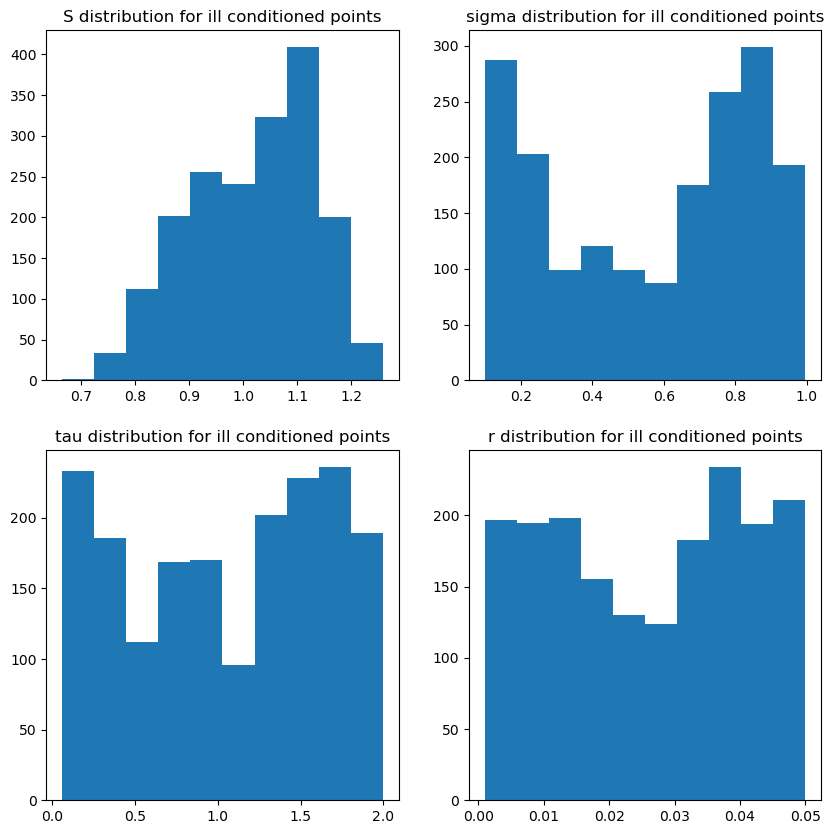

In [ ]:
# plot distributions of features for predictions that violate the light constrains (lb<=ub) 

fig, axs = plt.subplots(2, 2, figsize=(10,10))
for i, param in enumerate(['S', 'sigma', 'tau', 'r']):
    ax = axs[int(i/2), i%2]
    ax.hist(df.loc[np.logical_not(df.loc[:,'valid']), param], bins=10)
    ax.set_title(f'{param} distribution for ill conditioned points')

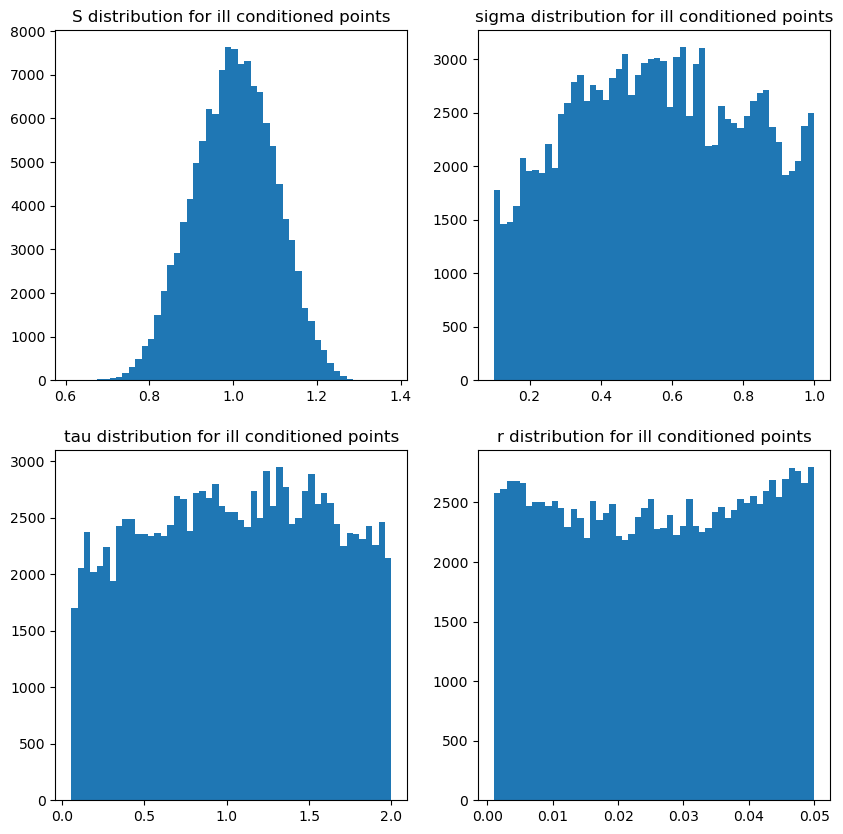

In [ ]:
# plot distributions of features for predictions that violate the full constrains (lb<=median<=ub) 

fig, axs = plt.subplots(2, 2, figsize=(10,10))
for i, param in enumerate(['S', 'sigma', 'tau', 'r']):
    ax = axs[int(i/2), i%2]
    ax.hist(df.loc[np.logical_not(df.loc[:,'pp_valid']), param], bins=50)
    ax.set_title(f'{param} distribution for ill conditioned points')

Distributions of ill conditioned predictions are similar to the marginal dists of the original data.

### Inspect ill ordered predictions of non conformal QR

In [ ]:
df_noncp = pd.concat((test_data, noncp_predictions[5]),axis=1)
# compute rank correlation
df_noncp.corr(method='spearman')

,S,sigma,tau,r,C,lb,pp,ub,valid,pp_valid
S,1.000000,-0.000243,0.001167,0.000168,0.453533,0.452527,0.453318,0.452778,0.002321,0.004792
sigma,-0.000243,1.000000,-0.000700,0.000038,0.683937,0.684915,0.684278,0.687003,0.035553,0.004496
tau,0.001167,-0.000700,1.000000,0.001217,0.494261,0.494616,0.494083,0.492628,0.008797,-0.004668
r,0.000168,0.000038,0.001217,1.000000,0.042018,0.039244,0.040669,0.039896,0.005683,0.010633
C,0.453533,0.683937,0.494261,0.042018,1.000000,0.999797,0.999865,0.999653,0.029200,-0.002432
lb,0.452527,0.684915,0.494616,0.039244,0.999797,1.000000,0.999791,0.999441,0.027331,-0.005273
pp,0.453318,0.684278,0.494083,0.040669,0.999865,0.999791,1.000000,0.999635,0.029214,-0.001596
ub,0.452778,0.687003,0.492628,0.039896,0.999653,0.999441,0.999635,1.000000,0.032509,0.002207
valid,0.002321,0.035553,0.008797,0.005683,0.029200,0.027331,0.029214,0.032509,1.000000,0.210781
pp_valid,0.004792,0.004496,-0.004668,0.010633,-0.002432,-0.005273,-0.001596,0.002207,0.210781,1.000000


In [ ]:
pd.concat((df.loc[:,["valid", "pp_valid"]].add_suffix('_cp'), df_noncp.loc[:,["valid", "pp_valid"]].add_suffix('_non-cp')),axis=1).corr(method='spearman')

,valid_cp,pp_valid_cp,valid_non-cp,pp_valid_non-cp
valid_cp,1.000000,0.105644,0.085821,0.038608
pp_valid_cp,0.105644,1.000000,0.075729,0.225397
valid_non-cp,0.085821,0.075729,1.000000,0.210781
pp_valid_non-cp,0.038608,0.225397,0.210781,1.000000


**There is not much correlation between ill conditioning for conformalized and non-conformalized QR**.

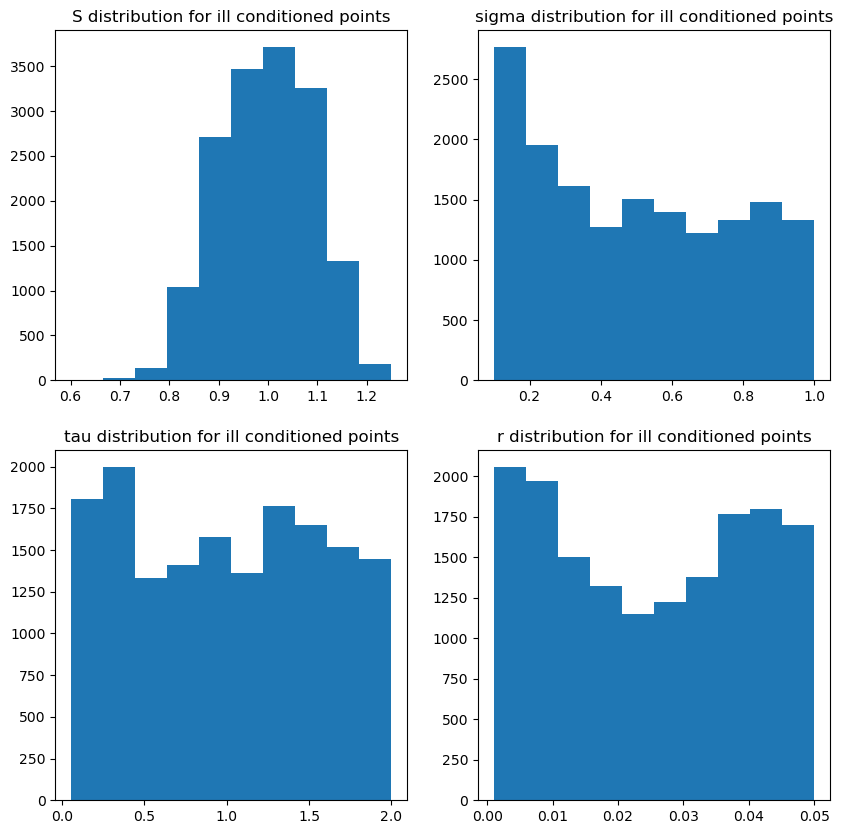

In [ ]:
# plot distributions of features for predictions that violate the light constrains (lb<=ub) 

fig, axs = plt.subplots(2, 2, figsize=(10,10))
for i, param in enumerate(['S', 'sigma', 'tau', 'r']):
    ax = axs[int(i/2), i%2]
    ax.hist(df_noncp.loc[np.logical_not(df_noncp.loc[:,'valid']), param], bins=10)
    ax.set_title(f'{param} distribution for ill conditioned points')

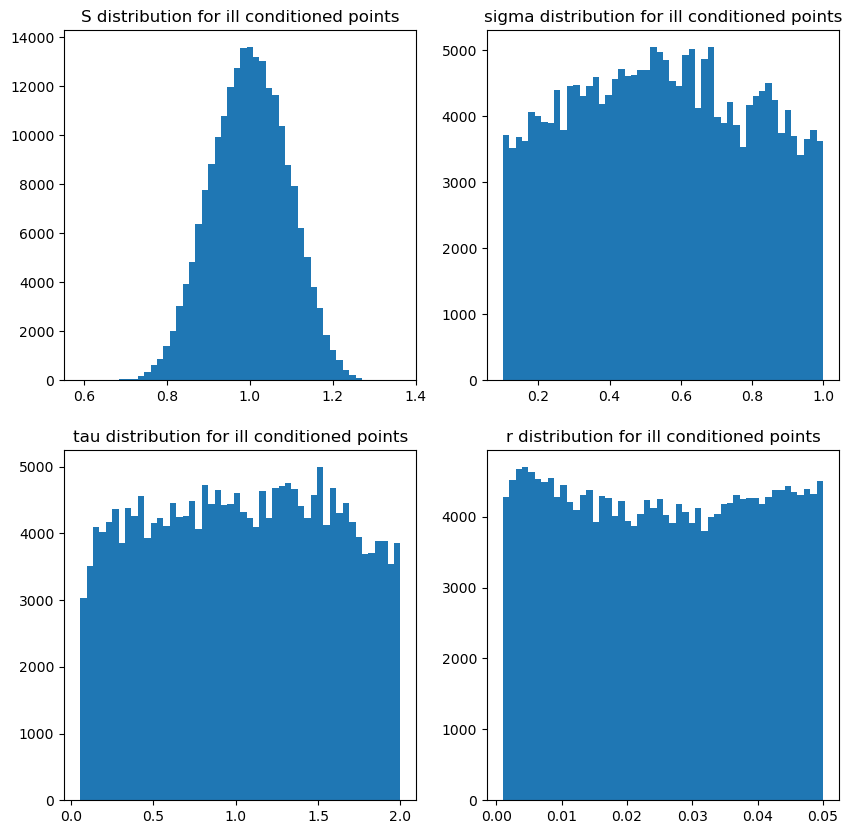

In [ ]:
# plot distributions of features for predictions that violate the full constrains (lb<=median<=ub) 

fig, axs = plt.subplots(2, 2, figsize=(10,10))
for i, param in enumerate(['S', 'sigma', 'tau', 'r']):
    ax = axs[int(i/2), i%2]
    ax.hist(df_noncp.loc[np.logical_not(df_noncp.loc[:,'pp_valid']), param], bins=50)
    ax.set_title(f'{param} distribution for ill conditioned points')

## Coverage

In [ ]:
for id in sample_ids:
    predictions = cp_predictions[id].loc[:,['lb', 'ub', 'valid']]

    df = pd.concat((test_data, predictions),axis=1)

    # filter out ill conditioned points
    df = df.loc[df.loc[:,'valid'],:]

    # compute the coverage
    coverage = np.mean((df.loc[:,'lb'] <= df.loc[:,'C']) & (df.loc[:,'C'] <= df.loc[:,'ub']))
    print(f"Coverage for sample {id}, method CQR:   {coverage:0.3f}")


Coverage for sample 0, method CQR:   0.885
Coverage for sample 1, method CQR:   0.879
Coverage for sample 2, method CQR:   0.883
Coverage for sample 3, method CQR:   0.887
Coverage for sample 4, method CQR:   0.892
Coverage for sample 5, method CQR:   0.887


In [ ]:
for id in sample_ids:
    predictions = noncp_predictions[id].loc[:,['lb', 'ub', 'valid']]

    df = pd.concat((test_data, predictions),axis=1)

    # filter out ill conditioned points
    df = df.loc[df.loc[:,'valid'],:]

    # compute the coverage
    coverage = np.mean((df.loc[:,'lb'] <= df.loc[:,'C']) & (df.loc[:,'C'] <= df.loc[:,'ub']))
    print(f"Coverage for sample {id}, non-cp QR:    {coverage:0.3f}")

Coverage for sample 0, non-cp QR:    0.616
Coverage for sample 1, non-cp QR:    0.629
Coverage for sample 2, non-cp QR:    0.643
Coverage for sample 3, non-cp QR:    0.686
Coverage for sample 4, non-cp QR:    0.703
Coverage for sample 5, non-cp QR:    0.732
